# Parameters

In [59]:
import numpy as np
import pandas as pd
from scipy.linalg import expm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import copy
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = (10, 6)
from tqdm import tqdm, trange

# Functions

Discretizing 7.33

\begin{align}
& \partial_t u ^\mu(t, x) + H^*(t,x, \mu_t, u^{\mu}(t, \cdot)) = 0\\
& \partial_t u ^\mu(t, x) + \lambda_t(x, \cdot, \mu_t, \hat{\alpha}) u^{\mu}(t, \cdot) + f(x) = 0\\
& \frac{u ^\mu(t+ \delta t, x) - u ^\mu(t, x)}{δt} + \frac{P_{x, \cdot}^{\mu_t, \hat{\alpha}}(\delta t) - P_{x, \cdot}^{\mu_t, \hat{\alpha}}(0)}{\delta t} u^{\mu}(t + \delta t, \cdot) + f(x) = 0 \\
& u ^\mu(t, x) = P_{x, \cdot}^{\mu_t, \hat{\alpha}}(\delta t)u^{\mu}(t + \delta t, \cdot) + f(x) \delta t
\end{align}

Discretizing 7.36

\begin{align}
& \partial_t \mu_t(x) = \mu_t(\cdot) \lambda_t(\cdot, x, \mu_t, \hat{\alpha})\\
& \frac{\mu_{t+ \delta t}(x) - \mu_t(x)}{\delta t} =  \mu_t(\cdot) \frac{P_{\cdot, x}^{\mu_t, \hat{\alpha}}(\delta t) - P_{\cdot, x}^{\mu_t, \hat{\alpha}}(0)}{\delta t} \\
& \mu_{t + \delta t}(x) = \mu_t(\cdot) P_{\cdot, x}^{\mu_t, \hat{\alpha}}(\delta t)
\end{align}

In [60]:
def get_qmat(mu, a, q_inf_U=0.3, q_inf_D=0.4, q_rec_D=0.5, q_rec_U=0.4,
             lambd=0.8, b_UU=0.3, b_UD=0.4, b_DU=0.3, b_DD=0.4,
             ν_H=0.6):
    '''
    Get infinitesimal generator matrix given measure and action
    Input:
    mu: dictionary or pd.series like {'DI': 0.25, 'DS': 0.25, 'UI': 0.25, 'US': 0.25}
    a: action in [0, 1]
    
    Output:
    Q: 4 X 4 matrix
    '''
    if a == 0:
        Q = np.array([
            [-q_rec_D, q_rec_D, 0, 0],
            [ν_H*q_inf_D + b_DD*mu['DI'] + b_UD*mu['UI'], - (ν_H*q_inf_D + b_DD*mu['DI'] + b_UD*mu['UI']), 0, 0],
            [0, 0, -q_rec_U , q_rec_U],
            [0, 0, ν_H*q_inf_U + b_UU*mu['UI']+ b_DU*mu['DI'], -(ν_H*q_inf_U + b_UU*mu['UI']+ b_DU*mu['DI'])]   
            ])
    elif a == 1:
        Q = np.array([
            [-(q_rec_D+lambd), q_rec_D, lambd, 0],
            [ν_H*q_inf_D + b_DD*mu['DI'] + b_UD*mu['UI'], - (ν_H*q_inf_D + b_DD*mu['DI'] + b_UD*mu['UI'] + lambd), 0, lambd],
            [lambd, 0, -(q_rec_U+lambd) , q_rec_U],
            [0, lambd, ν_H*q_inf_U + b_UU*mu['UI']+ b_DU*mu['DI'], -(ν_H*q_inf_U + b_UU*mu['UI']+ b_DU*mu['DI']+lambd)]   
            ])
    return Q

In [61]:
def get_f(k_D= 0.3, k_I= 0.5):
    '''
    Running cost function
    '''
    k = np.array([k_D + k_I, k_D, k_I, 0])
    return k

In [62]:
def solve_hjb(mu_flow, param_q, param_f):
    '''
    Solve discrete dynamic programming given a fixed 
    '''
    a_space = [0, 1]
    u = pd.DataFrame(np.zeros(mu_flow.shape), index=mu_flow.index, columns=mu_flow.columns)         # initialize value function
    a_flow = pd.DataFrame(np.zeros(mu_flow.shape), index=mu_flow.index, columns=mu_flow.columns)    # initialize action flow
    dt = mu_flow.index[1]                                                     # get time step
    
    f = get_f(**param_f)
    for t in reversed(range(len(u)-1)):
        mu = mu_flow.iloc[t]
        Q = [get_qmat(mu, a, **param_q) for a in a_space]         # Q matrix by mu and action
        P = [expm(q*dt) for q in Q]
        
        u_t_list = np.vstack([p@u.iloc[t+1] +  f*dt for p in P])  # Halmitonian * dt (7.33)
        u_t_list_min = u_t_list.min(axis=0)                       # min Halmitonian
        a = u_t_list.argmin(axis=0)                               # corresponding action
        u.iloc[t] = u_t_list_min                                  # record value funtion at t
        a_flow.iloc[t] = a                                        # record action at t
    return a_flow, u

In [63]:
def solve_flow(mu0, a_flow, param_q, param_f):
    mu_flow = pd.DataFrame(np.zeros(a_flow.shape),
                          index=a_flow.index, columns=a_flow.columns)
    mu_flow.iloc[0] = mu0
    
    t_len, x_len = a_flow.shape
    dt = a_flow.index[1]
    
    for t in range(t_len-1):
        mu = mu_flow.iloc[t]
        ax = a_flow.iloc[t]
        mu_new = mu @ [expm(get_qmat(mu, ax[x], **param_q) *dt)[x]             # KFP eqn (7.36)
                     for x in range(x_len)]
        mu_flow.iloc[t+1] = mu_new
    return mu_flow

In [64]:
def solve_fixpoint(mu0, param_q, param_f, T=10, n=1000, iterations=1):
    tline = np.linspace(0, T, n+1)
    dt = T/n
    mu_flow = pd.DataFrame(np.random.dirichlet(np.ones(len(mu0)), size=len(tline)),
                          index=tline, columns=mu0.index)

    a_flow_list = []
    mu_flow_list = []
    for i in range(iterations):
        a_flow, _ = solve_hjb(mu_flow, param_q, param_f)
        mu_flow = solve_flow(mu0, a_flow, param_q, param_f)


        mu_flow_list.append(mu_flow)
        a_flow_list.append(a_flow)
    
    return (mu_flow_list, a_flow_list)

In [65]:
# Param for discretization
T = 10
n = 1000
tline = np.linspace(0, T, n+1)

# Param for plot
param_plot={ 'style': ['-', '--', ':', '-.'],
    'color': ['black', 'red', 'green', 'blue'],
    'ylim': [-0.02,1.02],
    'xlim': [-0.2, T+0.2]}

# Parameter set 1
param_q = {'q_inf_U': 0.3, 'q_inf_D': 0.4, 'q_rec_D': 0.5, 'q_rec_U': 0.4,
           'b_UU': 0.3, 'b_UD': 0.4, 'b_DU': 0.3, 'b_DD': 0.4,
           'lambd': 0.8,'ν_H': 0.6}

param_f = {'k_D': 0.3, 'k_I': 0.5}

# Parameter set 2
param_q2 = {'q_inf_U': 0.3, 'q_inf_D': 0.4, 'q_rec_D': 0.3, 'q_rec_U': 0.3,
            'b_UU': 5, 'b_UD': 5, 'b_DU': 2, 'b_DD': 2,
            'lambd': 100000000, 'ν_H': 0.6}

param_f2 = {'k_D': 0.5385, 'k_I': 1}

# Fig 7.1

In [66]:
mu0_1 = pd.Series([0.25, 0.25, 0.25, 0.25], index=['DI', 'DS', 'UI', 'US'])
mu0_2 = pd.Series([1, 0, 0, 0], index=['DI', 'DS', 'UI', 'US'])
mu0_3 = pd.Series([0, 0, 0, 1], index=['DI', 'DS', 'UI', 'US'])

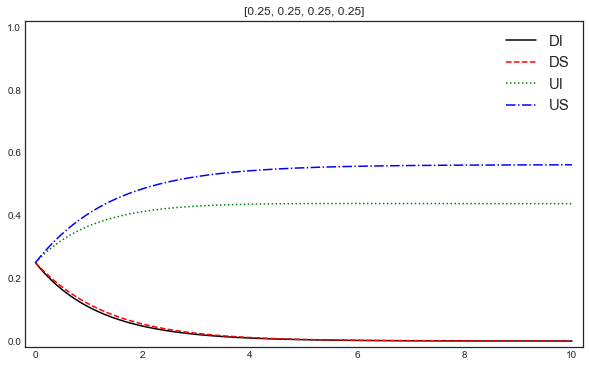

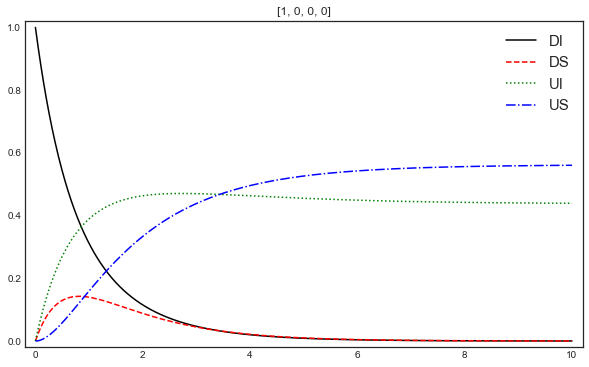

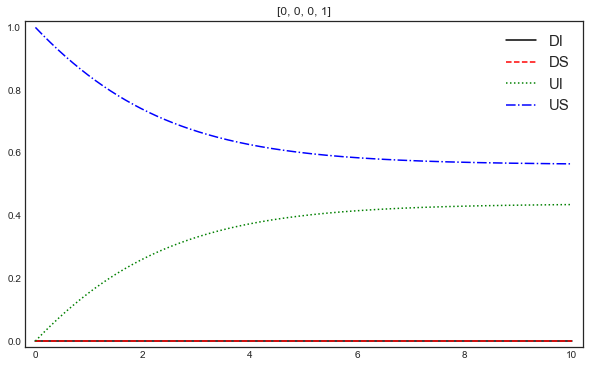

In [67]:
for mu0 in [mu0_1, mu0_2, mu0_3]:
    mu_flow_list, a_flow_list = solve_fixpoint(mu0, param_q, param_f)
    mu_flow_list[-1].plot(**param_plot)
    plt.title(mu0.values.tolist())
    plt.legend(fontsize=15)

# Fig 7.2

The reason $a(T,x) =0$ 0 at the right end is because $g(X_T) \equiv 0$ and action doesn't matter.

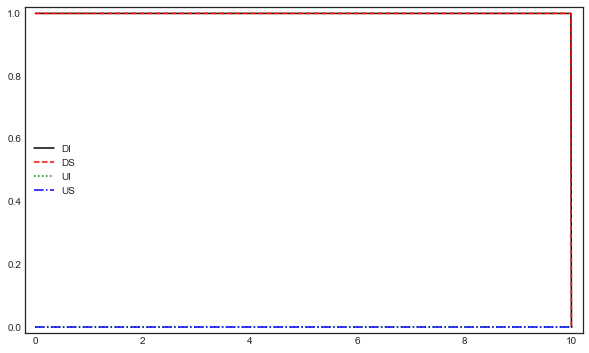

In [68]:
a_flow_list[-1].plot(**param_plot);

# Fig 7.3

In [69]:
mu_flow_list, a_flow_list = solve_fixpoint(mu0_1, param_q2, param_f2, iterations=5)

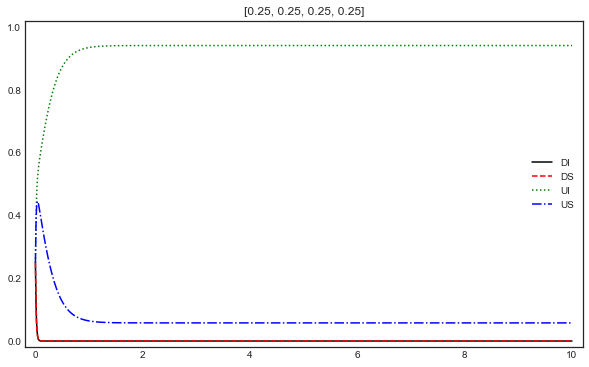

In [70]:
mu_flow_list[0].plot(**param_plot)
plt.title(mu0_1.values.tolist());

## it doesn't iterate

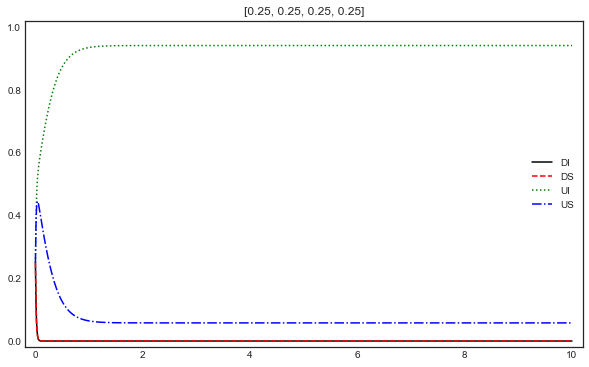

In [71]:
mu_flow_list[-1].plot(**param_plot)
plt.title(mu0_1.values.tolist());